To begin, we have the time dependent Schrödinger equation

$$H\psi(x,t) = i\hbar\frac{\partial\psi(x,t)}{\partial t}$$

Where $\psi(x, t = 0)$ takes the Gaussian form

$$\psi(x) = \frac{1}{\sqrt[4]{2\pi\sigma^2}}e^{-\left(\frac{x-x_0}{2\sigma}\right)^2}e^{ik_0x}$$

We use function psi() to generate our initial wave.

In [1]:
import numpy as np

#generate wavefunction
def psi(x, x0, sigma, k0): 
    coeff = 1 / np.sqrt(2 * np.pi * sigma**2)**(1/4)
    exponential = np.exp(-((x - x0) / (2 * sigma))**2)
    phase = np.exp(1j * k0 * x)
    return coeff * exponential * phase

Space is then discretised and a time evolution step is set, i.e. how fast the system progresses. We also plot the real and imaginary parts of our wave alongside the probability amplitude. Note that the wave only has an imaginary component if we take $k_0 \ne 0$.

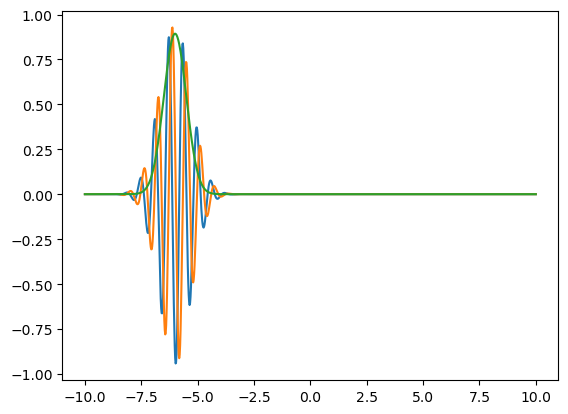

In [2]:
from matplotlib import pyplot as plt

#discretise space and set time step
n = 1000
x = np.linspace(-10, 10, n)
dx = x[1] - x[0]
dt = 0.01

#set initial wavefunction parameters
psi_values = psi(x, -6, 0.5, 10)

#plot
plt.plot(x, np.real(psi_values))
plt.plot(x, np.imag(psi_values))
plt.plot(x, np.abs(psi_values)**2)

Next, we add our potential function, which in this case we give the shape of a barrier. The potential is plotted alongside the wave.

In [3]:
#potential function
def potential_function(x, barrier_position, barrier_width, barrier_height):
    potential_array = np.zeros_like(x) 
    barrier_mask = np.logical_and(x >= barrier_position, x <= barrier_position + barrier_width)  
    potential_array[barrier_mask] = barrier_height
    return potential_array

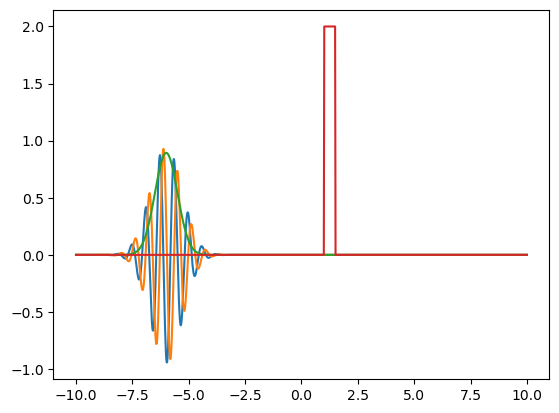

In [4]:
#potential parameters
V = potential_function(x, 1, 0.5, 2)

#plot
plt.plot(x, np.real(psi_values))
plt.plot(x, np.imag(psi_values))
plt.plot(x, np.abs(psi_values)**2)
plt.plot(x, V)

The Hamiltonian is now constructed as

$$H\psi = -\frac{1}{2}\frac{\partial\psi(x)^2}{\partial x^2} + V\psi(x)$$

and we can represent the second order derivative as a matrix through use of a finite difference scheme, giving us


$$
H\psi(x) = 
\frac{1}{2dx^2} \begin{bmatrix}
2 & -1 & 0 & \ldots & 0 \\
-1 & 2 & -1 & \ldots & 0 \\
0 & -1 & 2 & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & \ldots & 0 & -1 & 2 \\
\end{bmatrix}\psi(x) + V\psi(x)
$$

where the potential array is placed along the main diagonal of an equally sized matrix.


In [5]:
from scipy import sparse as sparse

#construct hamiltonian
H = -0.5 * (1 / dx**2) * ((sparse.diags([1, -2, 1], [-1, 0, 1], shape=(n, n))) + sparse.diags(V))

Now we must find how the system changes at each time step, we discretise time and construct explicit and implicit versions of the time dependent equation.

$$\frac{\psi(x, t + dt) - \psi(x, t)}{dt} = -iH\psi(x,t)$$
$$\frac{\psi(x, t + dt) - \psi(x, t)}{dt} = -iH\psi(x,t + dt)$$


According to the Crank-Nicolson scheme, these equations are averaged to obtain a time evolution operator.

$$\psi(x, t + dt) - \psi(x, t) = \frac{1}{2}dt(-iH\psi(x,t) \times -iH\psi(x,t + dt))$$
$$\psi(x, t + dt) - \psi(x, t) = \frac{dt}{2i}H\psi(x,t) + \frac{dt}{2i}H\psi(x,t + dt)$$
$$\psi(x, t + dt) = (1-\frac{dt}{2i}H)^{-1}(1+\frac{dt}{2i}H)\psi(x, t)$$

So now, if we have an initial wavefunction, the wavefucntion at the next step can be found.

In [6]:
from scipy.sparse import csr_matrix, eye, diags
from scipy.sparse.linalg import inv

identity = eye(len(x))

#implicity and explicit matricies
forward = csr_matrix(identity + 1j * dt / 2.0 * H)
backward = csr_matrix(identity - 1j * dt / 2.0 * H)

#convert to csc form for faster maths
forward_csc = forward.tocsc()
backward_csc = backward.tocsc()  

#crank-nicolson operator
cn = inv(forward_csc).dot(backward_csc)

With the Crank-Nicolson matrix constructed we can apply it to our initial wavefunction and create an animation.

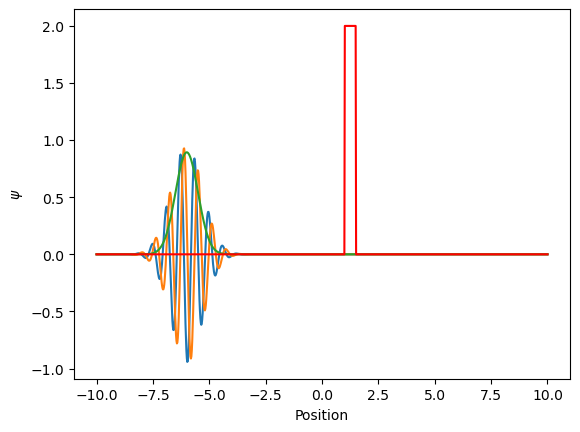

In [7]:
#initialise animated plot
fig, ax = plt.subplots()
ax.set_xlabel('Position')
ax.set_ylabel('$\psi$')
real_line, = ax.plot(x, np.real(psi_values), label= '$Re$')
imag_line, = ax.plot(x, np.imag(psi_values), label= '$Im$')
density_line, = ax.plot(x, np.abs(psi_values)**2, label= '$|\psi|^2$')
potential_line, = ax.plot(x, V, color='red', label= '$V$')

In [8]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML

#update current frame of plot animation
def update(frame):
    global psi_values
    
    psi_values = cn.dot(psi_values)
    psi_values[0] = psi_values[-1] = 0
    real_line.set_data(x, np.real(psi_values))
    imag_line.set_data(x, np.imag(psi_values))
    density_line.set_data(x, np.abs(psi_values)**2)
    potential_line.set_data(x, V)

    return density_line

ax.legend()

#animate plot
animation = FuncAnimation(fig, update, frames = 200, interval = 50)
plt.close()

#display as html5
plt.rcParams['animation.html'] = 'html5'
HTML(animation.to_html5_video())


References:

https://web.physics.utah.edu/~detar/phycs6730/handouts/crank_nicholson/crank_nicholson/
https://ben.land/post/2022/03/09/quantum-mechanics-simulation/#wave-functions
https://physicspython.wordpress.com/2019/10/27/quantum-tunneling-part-3/
https://medium.com/intuition/solve-the-time-dependent-schr%C3%B6dinger-equation-in-less-than-12-lines-of-python-3663077b1fbd